In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [3]:
# import trip data
df = pd.read_csv('data/citibike_ZIP.csv')

In [4]:
# find total number of trip starts and ends by zipcode
start_count = df.groupby(['zip_start'], as_index=False)['bikeid'].count()
start_count.columns = ['zip_start','start_count']
start_count.head()

,zip_start,start_count
0,83,70803
1,10001,63816
2,10002,78029
3,10003,92930
4,10004,10921


In [5]:
end_count = df.groupby(['zip_end'], as_index=False)['bikeid'].count()
end_count.columns = ['zip_end','end_count']
end_count.head()

,zip_end,end_count
0,83.0,69557
1,10001.0,63180
2,10002.0,78867
3,10003.0,93889
4,10004.0,11250


In [6]:
zip_count = start_count.merge(end_count,
                             left_on = 'zip_start',
                             right_on = 'zip_end',
                             how = 'left')
zip_count.head()

,zip_start,start_count,zip_end,end_count
0,83,70803,83.0,69557
1,10001,63816,10001.0,63180
2,10002,78029,10002.0,78867
3,10003,92930,10003.0,93889
4,10004,10921,10004.0,11250


In [7]:
# import zip code shapefile
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')[['ZIPCODE', 'geometry']]
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)

In [8]:
# merge trip counts with shapefile
zip_shp = zip_shp.merge(
    zip_count, 
    left_on='ZIPCODE',
    right_on='zip_start',
    how='left')
zip_shp.head()

,ZIPCODE,geometry,zip_start,start_count,zip_end,end_count
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",NaN,NaN,NaN,NaN
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",NaN,NaN,NaN,NaN
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",NaN,NaN,NaN,NaN
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18...",11225.0,9237.0,11225.0,9316.0
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17...",NaN,NaN,NaN,NaN


In [9]:
zip_shp['start_count'].fillna(0, inplace=True)
zip_shp['end_count'].fillna(0, inplace=True)

In [11]:
# define total surplus as difference between end count and start count in each zipcode
# find daily average by dividing by 30

zip_shp['surplus_tot'] = zip_shp['end_count'] - zip_shp['start_count']
zip_shp['surplus_daily'] = zip_shp['surplus_tot']/30
zip_shp['surplus_daily'].describe()

count    263.000000
mean       0.175792
std       10.200333
min      -67.100000
25%        0.000000
50%        0.000000
75%        0.000000
max       73.833333
Name: surplus_daily, dtype: float64

[]

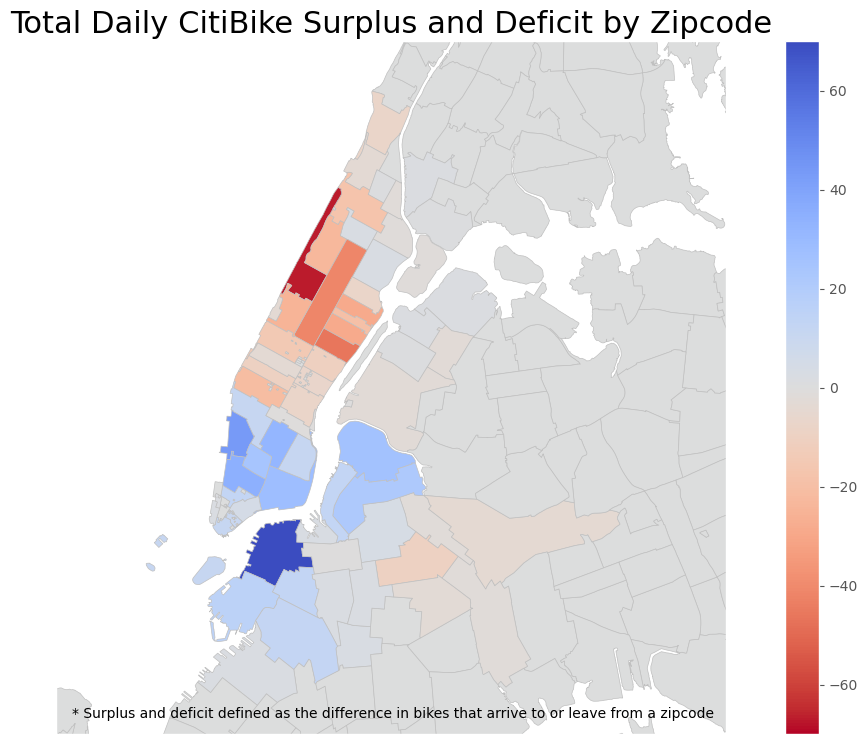

In [24]:
# choropleth of total surplus and deficit by zipcode

from matplotlib.colors import Normalize
norm = Normalize(vmin=-70, vmax=70)

fig, ax = plt.subplots(figsize = (15,9))

zip_shp.plot(ax=ax, column= 'surplus_daily', cmap='coolwarm_r', norm=norm, edgecolor = 'silver', legend=True)

plt.title('Total Daily CitiBike Surplus and Deficit by Zipcode', fontsize = 22)
plt.text(962000, 172056, '* Surplus and deficit defined as the difference in bikes that arrive to or leave from a zipcode')

ax.set_xlim(960000, 1042546)
ax.set_ylim(170056, 255352)
ax.set_facecolor("white")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])